# Modelo Orientado a Objetos - Equação de Burgers

Diante da necessidade de estruturar o código de maneira mais clara e adequada e também da possibilidade de adicionar novas funcionalidades, como validação e testes, foi lançado mão a orientação a objetos, a qual será abordada neste notebook.

O objetivo é resolver a equação de Burgers em duas dimensões:

\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = \nu \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)
\end{equation}

\begin{equation}
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = \nu \left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} + \right)
\end{equation}

### Instalação de Dependências e Configurações

In [1]:
!pip install plotly --quiet
!pip install wandb -qU --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt

import wandb

np.random.seed(1)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Em seguida, vamos conectar ao Google Drive, para conseguir exporar os modelos gerados.

Agora, vamos configurar o W&B para capturar a evolução do treinamento e sua otimização.

In [2]:
wandb.init(project='ic_pinn', entity='lucarvalho')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: lucarvalho. Use `wandb login --relogin` to force relogin


In [3]:
# sweep_config = {
#                 'method': 'random',
#                 'metric': {'goal': 'minimize', 'name': 'loss'},
#                 'parameters': {
#                     'comprimento_y': {
#                         'distribution': 'uniform',
#                         'max': 0.5,
#                         'min': 1.5,
#                     },
#                     'comprimento_x': {
#                         'distribution': 'uniform',
#                         'max': 0.5,
#                         'min': 1.5,
#                     },
#                     'tempo_final': {
#                         'distribution': 'uniform',
#                         'max': 0.5,
#                         'min': 1.5,
#                     },

#                     'epocas': {'value': 10000},

#                     'learning_rate': {
#                           'distribution': 'uniform',
#                           'max': 0.1,
#                           'min': 0
#                     },
#                     'alpha': {
#                         'distribution': 'uniform',
#                         'max': 0.3,
#                         'min': 0.05
#                     },
#                 }
#  }

In [4]:
# sweep_id = wandb.sweep(sweep_config, project="ic_pinn")

## Definição da Classe

Na abordagem orientada a objetos nesta implementação, a classe apresenta um cosntrutor que define os principais parâmetros da rede, ao passo que cada um dos métodos são, na realidade, passos pequenas passos na abordagem da solução.

Primeiramente, a definição de um bloco residual para implementar skip connections.

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(in_features, out_features)
        self.linear2 = nn.Linear(out_features, out_features)

        # Adicionar camada linear para ajustar dimensões, se necessário
        if in_features != out_features:
            self.adjust_dimensions = nn.Linear(in_features, out_features)
        else:
            self.adjust_dimensions = None

    def forward(self, x):
        residual = x
        x = torch.tanh(self.linear1(x))  # Modificado para tangente hiperbólica
        x = self.linear2(x)

        # Ajustar dimensões da entrada residual, se necessário
        if self.adjust_dimensions is not None:
            residual = self.adjust_dimensions(residual)

        if residual.shape[1] == x.shape[1]:  # Verifica se as dimensões são compatíveis para a conexão de pulo
            x += residual  # Conexão de pulo
        else:
            raise RuntimeError("Dimensões incompatíveis para a conexão de pulo.")
        return torch.tanh(x)  # Modificado para tangente hiperbólica como ativação

Agora, a definição da classe pinn

In [6]:
class pinn:

  # Método contrutor
  def __init__(self, comprimento_x: int = 1, comprimento_y: int = 1, tempo_final: int = 1,
    pontos_no_contorno: int = 1000, pontos_no_dominio: int = 2000, numero_de_neuronios = [3, 20, 20, 20, 2],
    pontos_no_contorno_validacao: int = 200, pontos_no_dominio_validacao: int = 300,
    alpha: float = 0.2, epocas: int = 20000, learning_rate: float = 0.01,
    train: bool = False, verbose: bool = False, max_time = None,
    device = torch.device('cuda' if torch.cuda.is_available () else 'cpu')):

    self.comprimento_x = comprimento_x
    self.comprimento_y = comprimento_y
    self.tempo_final = tempo_final
    self.alpha = alpha
    self.epocas = epocas
    self.learning_rate = learning_rate
    self.pontos_no_contorno = pontos_no_contorno
    self.pontos_no_dominio = pontos_no_dominio
    self.numero_de_neuronios = numero_de_neuronios
    self.learning_rate = learning_rate
    self.pontos_no_contorno_validacao = pontos_no_contorno_validacao
    self.pontos_no_dominio_validacao = pontos_no_dominio_validacao

    if type(device) == str:
      device = torch.device(device)
    self.device = device

    if train:
      self.treinamento_da_rede()

  def gerar_lado(self, pontos_por_lado, comprimento_x, comprimento_y, tempo_final, velocidade = 0):
        x = np.random.uniform(size=(pontos_por_lado, 1), low=0, high=comprimento_x)
        y = np.random.uniform(size=(pontos_por_lado, 1), low=0, high=comprimento_y)
        t = np.random.uniform(size=(pontos_por_lado, 1), low=0, high=tempo_final)
        if (velocidade == 0):
          u = 0 * np.ones((pontos_por_lado, 1))
          v = 0 * np.ones((pontos_por_lado, 1))
        else:
          u = np.sin(2*np.pi*x)*np.sin(2*np.pi*y)
          v = np.sin(np.pi*x)*np.sin(np.pi*y)

        return x, y, t, u, v

  def gerar_pontos_contorno(self):
        pontos_por_lado = self.pontos_no_contorno // 6
        x1, y1, t1, u1, v1 = self.gerar_lado(pontos_por_lado, self.comprimento_x, 0, self.tempo_final)
        x2, y2, t2, u2, v2 = self.gerar_lado(pontos_por_lado, 0, self.comprimento_y, self.tempo_final)
        x3, y3, t3, u3, v3 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)
        x4, y4, t4, u4, v4 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)

        x_inicial, y_inicial, t_inicial, u_inicial, v_inicial = self.gerar_lado(
            2 * pontos_por_lado, self.comprimento_x, self.comprimento_y, 0, 1
        )

        # Juntar todos os lados
        x_todos = np.vstack((x1, x2, x3, x4, x_inicial))
        y_todos = np.vstack((y1, y2, y3, y4, y_inicial))
        t_todos = np.vstack((t1, t2, t3, t4, t_inicial))
        u_todos = np.vstack((u1, u2, u3, u4, u_inicial))
        v_todos = np.vstack((v1, v2, v3, v4, v_inicial))

        # Criar arrays X e Y
        X_contorno = np.hstack((x_todos, y_todos, t_todos))
        Y_contorno = np.hstack((u_todos, v_todos))

        self.X_contorno = X_contorno
        self.Y_contorno = Y_contorno

  def gerar_pontos_validacao(self):
        pontos_por_lado_validacao = self.pontos_no_contorno_validacao // 6
        x1, y1, t1, u1, v1 = self.gerar_lado(pontos_por_lado_validacao, self.comprimento_x, 0, self.tempo_final)
        x2, y2, t2, u2, v2 = self.gerar_lado(pontos_por_lado_validacao, 0, self.comprimento_y, self.tempo_final)
        x3, y3, t3, u3, v3 = self.gerar_lado(pontos_por_lado_validacao, self.comprimento_x, self.comprimento_y, self.tempo_final)
        x4, y4, t4, u4, v4 = self.gerar_lado(pontos_por_lado_validacao, self.comprimento_x, self.comprimento_y, self.tempo_final)

        x_inicial_validacao, y_inicial_validacao, t_inicial_validacao, u_inicial_validacao, v_inicial_validacao = self.gerar_lado(
            2 * pontos_por_lado_validacao, self.comprimento_x, self.comprimento_y, 0, 1
        )

        # Juntar todos os lados em validação
        x_todos_validacao = np.vstack((x1, x2, x3, x4, x_inicial_validacao))
        y_todos_validacao = np.vstack((y1, y2, y3, y4, y_inicial_validacao))
        t_todos_validacao = np.vstack((t1, t2, t3, t4, t_inicial_validacao))
        u_todos_validacao = np.vstack((u1, u2, u3, u4, u_inicial_validacao))
        v_todos_validacao = np.vstack((v1, v2, v3, v4, v_inicial_validacao))

        # Arrays X e Y para validação
        X_contorno_validacao = np.hstack((x_todos_validacao, y_todos_validacao, t_todos_validacao))
        Y_contorno_validacao = np.hstack((u_todos_validacao, v_todos_validacao))

        self.X_contorno_validacao = X_contorno_validacao
        self.Y_contorno_validacao = Y_contorno_validacao

  def gerar_pontos_equacao(self):
    x_dominio = np.random.uniform(size=(self.pontos_no_dominio, 1), low=0, high=self.comprimento_x)
    y_dominio = np.random.uniform(size=(self.pontos_no_dominio, 1), low=0, high=self.comprimento_y)
    t_dominio = np.random.uniform(size=(self.pontos_no_dominio, 1), low=0, high=self.tempo_final)

    x_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao, 1), low=0, high=self.comprimento_x)
    y_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao, 1), low=0, high=self.comprimento_y)
    t_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao, 1), low=0, high=self.tempo_final)

    X_equacao = np.hstack((x_dominio, y_dominio, t_dominio))
    X_equacao_validacao = np.hstack((x_dominio_validacao, y_dominio_validacao, t_dominio_validacao))

    self.X_equacao = torch.tensor(X_equacao, requires_grad=True, dtype=torch.float).to(self.device)
    self.X_equacao_validacao = torch.tensor(X_equacao_validacao, requires_grad=True, dtype=torch.float).to(self.device)

  def criar_rede_neural(self):
        # Criar uma lista de todas as camadas
        camadas = []

        # Adicionar camadas residuais
        for i in range(len(self.numero_de_neuronios)-2):
            camadas.append(ResidualBlock(self.numero_de_neuronios[i], self.numero_de_neuronios[i + 1]))

            # adicionar dropout
            # camadas.append(nn.Dropout(p=0.5))

        # Última camada sem ativação (pode ser ajustado conforme necessário)
        camadas.append(nn.Linear(self.numero_de_neuronios[-2], self.numero_de_neuronios[-1]))

        # Criar a rede
        self.rna = nn.Sequential(*camadas)

  def calc_perda_contorno(self):
    Y_predito = self.rna(self.X_contorno)
    Y_predito_validacao = self.rna(self.X_contorno_validacao)

    perda_contorno = nn.functional.mse_loss(Y_predito, self.Y_contorno)
    perda_contorno_validacao = nn.functional.mse_loss(Y_predito_validacao, self.Y_contorno_validacao)

    self.perda_contorno = perda_contorno
    self.perda_contorno_validacao = perda_contorno_validacao

  def regerar_pontos_contorno(self):
    pontos_por_lado = self.pontos_no_contorno // 6
    x1, y1, t1, u1, v1 = self.gerar_lado(pontos_por_lado, self.comprimento_x, 0, self.tempo_final)
    x2, y2, t2, u2, v2 = self.gerar_lado(pontos_por_lado, 0, self.comprimento_y, self.tempo_final)
    x3, y3, t3, u3, v3 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)
    x4, y4, t4, u4, v4 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)

    x_inicial, y_inicial, t_inicial, u_inicial, v_inicial = self.gerar_lado(
        2 * pontos_por_lado, self.comprimento_x, self.comprimento_y, 0, 1
    )

    # Juntar todos os lados
    x_todos = np.vstack((x1, x2, x3, x4, x_inicial))
    y_todos = np.vstack((y1, y2, y3, y4, y_inicial))
    t_todos = np.vstack((t1, t2, t3, t4, t_inicial))
    u_todos = np.vstack((u1, u2, u3, u4, u_inicial))
    v_todos = np.vstack((v1, v2, v3, v4, v_inicial))

    # Criar arrays X e Y
    X_contorno = np.hstack((x_todos, y_todos, t_todos))
    Y_contorno = np.hstack((u_todos, v_todos))

    # Converter para tensores
    # X_contorno = torch.tensor(X_contorno, requires_grad=True, dtype=torch.float).to(self.device)
    # Y_contorno = torch.tensor(Y_contorno, requires_grad=True, dtype=torch.float).to(self.device)

    X_contorno = torch.tensor(X_contorno, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)
    Y_contorno = torch.tensor(Y_contorno, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)

    self.X_contorno = X_contorno
    self.Y_contorno = Y_contorno

  def regerar_pontos_equacao(self):
    pontos_por_lado = self.pontos_no_dominio // 4

    x1, y1, t1, u1, v1 = self.gerar_lado(pontos_por_lado, self.comprimento_x, 0, self.tempo_final)
    x2, y2, t2, u2, v2 = self.gerar_lado(pontos_por_lado, 0, self.comprimento_y, self.tempo_final)
    x3, y3, t3, u3, v3 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)
    x4, y4, t4, u4, v4 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)

    # Juntar todos os lados
    x_todos = np.vstack((x1, x2, x3, x4))
    y_todos = np.vstack((y1, y2, y3, y4))
    t_todos = np.vstack((t1, t2, t3, t4))
    u_todos = np.vstack((u1, u2, u3, u4))
    v_todos = np.vstack((v1, v2, v3, v4))

    # Criar arrays X e Y
    X_equacao = np.hstack((x_todos, y_todos, t_todos))
    Y_equacao = np.hstack((u_todos, v_todos))

    # Converter para tensores
    X_equacao = torch.tensor(X_equacao, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)
    Y_equacao = torch.tensor(Y_equacao, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)

    self.X_equacao = X_equacao
    self.Y_equacao = Y_equacao


  def calcular_gradientes(self, u, v, x, y, t):
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        return u_x, u_xx, u_y, u_yy, v_x, v_xx, v_y, v_yy, u_t, v_t

  def calc_residuo(self):
        x = self.X_equacao[:, 0].reshape(-1, 1)
        y = self.X_equacao[:, 1].reshape(-1, 1)
        t = self.X_equacao[:, 2].reshape(-1, 1)

        x_validacao = self.X_equacao_validacao[:, 0].reshape(-1, 1)
        y_validacao = self.X_equacao_validacao[:, 1].reshape(-1, 1)
        t_validacao = self.X_equacao_validacao[:, 2].reshape(-1, 1)

        V = self.rna(torch.hstack((x, y, t)))
        u = V[:, 0].reshape(-1, 1)
        v = V[:, 1].reshape(-1, 1)

        V_validacao = self.rna(torch.hstack((x_validacao, y_validacao, t_validacao)))
        u_validacao = V_validacao[:, 0].reshape(-1, 1)
        v_validacao = V_validacao[:, 1].reshape(-1, 1)

        u_x, u_xx, u_y, u_yy, v_x, v_xx, v_y, v_yy, u_t, v_t = self.calcular_gradientes(u, v, x, y, t)
        u_x_validacao, u_xx_validacao, u_y_validacao, u_yy_validacao, v_x_validacao, v_xx_validacao, v_y_validacao, v_yy_validacao, u_t_validacao, v_t_validacao = self.calcular_gradientes(u_validacao, v_validacao, x_validacao, y_validacao, t_validacao)

        residual_u = (u_t + u * u_x + v * u_y - 0.01/np.pi * (u_xx + u_yy))
        residual_v = (v_t + u * v_x + v * v_y - 0.01/np.pi * (v_xx + v_yy))

        residual_u_validacao = (u_t_validacao + u_validacao * u_x_validacao + v_validacao * u_y_validacao - 0.01/np.pi * (u_xx_validacao + u_yy_validacao))
        residual_v_validacao = (v_t_validacao + u_validacao * v_x_validacao + v_validacao * v_y_validacao - 0.01/np.pi * (v_xx_validacao + v_yy_validacao))

        residuo_total = torch.cat((residual_u, residual_v), dim=1)
        self.residuo_total = residuo_total

        residuo_total_validacao = torch.cat((residual_u_validacao, residual_v_validacao), dim=1)
        self.residuo_total_validacao = residuo_total_validacao
        return residuo_total_validacao

  def calc_perda_equacao(self):
    self.calc_residuo()
    residuo = torch.mean(torch.square(self.residuo_total))
    residuo_validacao = torch.mean(torch.square(self.residuo_total_validacao))

    self.perda_equacao = residuo
    self.perda_equacao_validacao = residuo_validacao

  def calc_perda(self):

    self.calc_perda_contorno()
    self.calc_perda_equacao()

    perda = (1-self.alpha)*self.perda_contorno + self.alpha*self.perda_equacao
    perda_validacao = (1-self.alpha)*self.perda_contorno_validacao + self.alpha*self.perda_equacao_validacao

    self.perda = perda
    self.perda_validacao = perda_validacao
    self.perda_contorno = self.perda_contorno
    self.perda_contorno_validacao = self.perda_contorno_validacao
    self.perda_equacao = self.perda_equacao
    self.perda_equacao_validacao = self.perda_equacao_validacao

  def definicao_otimizador(self):
      self.gerar_pontos_validacao()
      otimizador = torch.optim.Adam(self.rna.parameters(),self.learning_rate)
      agendador = torch.optim.lr_scheduler.StepLR(otimizador, step_size=1000, gamma=0.9)

      self.X_equacao = torch.tensor(self.X_equacao,requires_grad=True,dtype=torch.float)
      self.X_contorno = torch.tensor(self.X_contorno,dtype=torch.float)
      self.Y_contorno = torch.tensor(self.Y_contorno,dtype=torch.float)

      self.X_equacao = self.X_equacao.to(self.device)
      self.X_contorno = self.X_contorno.to(self.device)
      self.Y_contorno = self.Y_contorno.to(self.device)
      self.rna = self.rna.to(self.device)

      self.X_equacao_validacao = torch.tensor(self.X_equacao_validacao,requires_grad=True,dtype=torch.float)
      self.X_contorno_validacao = torch.tensor(self.X_contorno_validacao,dtype=torch.float)
      self.Y_contorno_validacao = torch.tensor(self.Y_contorno_validacao,dtype=torch.float)

      self.X_equacao_validacao = self.X_equacao_validacao.to(self.device)
      self.X_contorno_validacao = self.X_contorno_validacao.to(self.device)
      self.Y_contorno_validacao = self.Y_contorno_validacao.to(self.device)
      self.rna = self.rna.to(self.device)

  def treinamento_da_rede(self):
    otimizador = torch.optim.Adam(self.rna.parameters(), lr=self.learning_rate, weight_decay=1e-5)
    agendador = torch.optim.lr_scheduler.StepLR(otimizador, step_size=1000, gamma=0.9)

    perda_historico = np.zeros(self.epocas)
    perda_contorno_historico = np.zeros(self.epocas)
    perda_equacao_historico = np.zeros(self.epocas)

    perda_historico_validacao = np.zeros(self.epocas)
    perda_contorno_historico_validacao = np.zeros(self.epocas)
    perda_equacao_historico_validacao = np.zeros(self.epocas)

    epocas = np.array(range(self.epocas))

    # Colocar rede em modo de treinamento
    self.rna.train()

    # FAZER ITERAÇÃO
    for epoca in epocas:
        # Resortear pontos
        # self.gerar_pontos_equacao()

        # Inicializar gradientes
        otimizador.zero_grad()

        # Calcular perdas
        self.calc_perda()

        # Backpropagation
        self.perda.backward()

        # Passo do otimizador
        otimizador.step()
        agendador.step()

        # Guardar logs
        perda_historico[epoca] = self.perda.item()
        perda_contorno_historico[epoca] = self.perda_contorno.item()
        perda_equacao_historico[epoca] = self.perda_equacao.item()

        perda_historico_validacao[epoca] = self.perda_validacao.item()
        perda_contorno_historico_validacao[epoca] = self.perda_contorno_validacao.item()
        perda_equacao_historico_validacao[epoca] = self.perda_equacao_validacao.item()

        for name, param in self.rna.named_parameters():
            wandb.log({f'Gradient/{name}': param.grad.norm().item()}, step=epoca)

        if epoca % 500 == 0:
            print(f'Epoca: {epoca}, Perda: {self.perda.item()} (Contorno: {self.perda_contorno.item()}, Equacao: {self.perda_equacao.item()})')
            print(f'Perda Validação: {self.perda_validacao.item()} (Contorno Validação: {self.perda_contorno_validacao.item()}, Equacao: {self.perda_equacao_validacao.item()})')
            wandb.log({'epoch': epoca, 'loss': self.perda.item()})

        # Ressortear os pontos - evitar overfitting
        # self.regerar_pontos_validacao()
        self.regerar_pontos_contorno()
        self.regerar_pontos_equacao()

    self.perda_historico = perda_historico
    self.perda_contorno_historico = perda_contorno_historico
    self.perda_equacao_historico = perda_equacao_historico

    self.perda_historico_validacao = perda_historico_validacao
    self.perda_contorno_historico_validacao = perda_contorno_historico_validacao
    self.perda_equacao_historico_validacao = perda_equacao_historico_validacao

  def plot_comparacao(self):
    # Plotar histórico
    epocas = np.array(range(self.epocas))
    plt.plot(epocas, self.perda_historico, 'b', label="Perda do treino")
    plt.plot(epocas, self.perda_historico_validacao, 'r', label="Perdas nos pontos de validação")
    plt.xlabel('Épocas')
    plt.ylabel('Perdas')
    plt.yscale('log')
    plt.legend()
    plt.show()


In [7]:

  # Método contrutor
  def __init__(self, comprimento_x: int = 1, comprimento_y: int = 1, tempo_final: int = 1,
    pontos_no_contorno: int = 1000, pontos_no_dominio: int = 2000, numero_de_neuronios = [3, 20, 20, 20, 2],
    pontos_no_contorno_validacao: int = 200, pontos_no_dominio_validacao: int = 300,
    alpha: float = 0.2, epocas: int = 20000, learning_rate: float = 0.01,
    train: bool = False, verbose: bool = False, max_time = None,
    device = torch.device('cuda' if torch.cuda.is_available () else 'cpu')):

    self.comprimento_x = comprimento_x
    self.comprimento_y = comprimento_y
    self.tempo_final = tempo_final
    self.alpha = alpha
    self.epocas = epocas
    self.learning_rate = learning_rate
    self.pontos_no_contorno = pontos_no_contorno
    self.pontos_no_dominio = pontos_no_dominio
    self.numero_de_neuronios = numero_de_neuronios
    self.learning_rate = learning_rate
    self.pontos_no_contorno_validacao = pontos_no_contorno_validacao
    self.pontos_no_dominio_validacao = pontos_no_dominio_validacao

    if type(device) == str:
      device = torch.device(device)
    self.device = device

    if train:
      self.treinamento_da_rede()

  def gerar_lado(self, pontos_por_lado, comprimento_x, comprimento_y, tempo_final, velocidade = 0):
        x = np.random.uniform(size=(pontos_por_lado, 1), low=0, high=comprimento_x)
        y = np.random.uniform(size=(pontos_por_lado, 1), low=0, high=comprimento_y)
        t = np.random.uniform(size=(pontos_por_lado, 1), low=0, high=tempo_final)
        if (velocidade == 0):
          u = 0 * np.ones((pontos_por_lado, 1))
          v = 0 * np.ones((pontos_por_lado, 1))
        else:
          u = np.sin(2*np.pi*x)*np.sin(2*np.pi*y)
          v = np.sin(np.pi*x)*np.sin(np.pi*y)

        return x, y, t, u, v

  def gerar_pontos_contorno(self):
        pontos_por_lado = self.pontos_no_contorno // 6
        x1, y1, t1, u1, v1 = self.gerar_lado(pontos_por_lado, self.comprimento_x, 0, self.tempo_final)
        x2, y2, t2, u2, v2 = self.gerar_lado(pontos_por_lado, 0, self.comprimento_y, self.tempo_final)
        x3, y3, t3, u3, v3 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)
        x4, y4, t4, u4, v4 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)

        x_inicial, y_inicial, t_inicial, u_inicial, v_inicial = self.gerar_lado(
            2 * pontos_por_lado, self.comprimento_x, self.comprimento_y, 0, 1
        )

        # Juntar todos os lados
        x_todos = np.vstack((x1, x2, x3, x4, x_inicial))
        y_todos = np.vstack((y1, y2, y3, y4, y_inicial))
        t_todos = np.vstack((t1, t2, t3, t4, t_inicial))
        u_todos = np.vstack((u1, u2, u3, u4, u_inicial))
        v_todos = np.vstack((v1, v2, v3, v4, v_inicial))

        # Criar arrays X e Y
        X_contorno = np.hstack((x_todos, y_todos, t_todos))
        Y_contorno = np.hstack((u_todos, v_todos))

        self.X_contorno = X_contorno
        self.Y_contorno = Y_contorno

  def gerar_pontos_validacao(self):
        pontos_por_lado_validacao = self.pontos_no_contorno_validacao // 6
        x1, y1, t1, u1, v1 = self.gerar_lado(pontos_por_lado_validacao, self.comprimento_x, 0, self.tempo_final)
        x2, y2, t2, u2, v2 = self.gerar_lado(pontos_por_lado_validacao, 0, self.comprimento_y, self.tempo_final)
        x3, y3, t3, u3, v3 = self.gerar_lado(pontos_por_lado_validacao, self.comprimento_x, self.comprimento_y, self.tempo_final)
        x4, y4, t4, u4, v4 = self.gerar_lado(pontos_por_lado_validacao, self.comprimento_x, self.comprimento_y, self.tempo_final)

        x_inicial_validacao, y_inicial_validacao, t_inicial_validacao, u_inicial_validacao, v_inicial_validacao = self.gerar_lado(
            2 * pontos_por_lado_validacao, self.comprimento_x, self.comprimento_y, 0, 1
        )

        # Juntar todos os lados em validação
        x_todos_validacao = np.vstack((x1, x2, x3, x4, x_inicial_validacao))
        y_todos_validacao = np.vstack((y1, y2, y3, y4, y_inicial_validacao))
        t_todos_validacao = np.vstack((t1, t2, t3, t4, t_inicial_validacao))
        u_todos_validacao = np.vstack((u1, u2, u3, u4, u_inicial_validacao))
        v_todos_validacao = np.vstack((v1, v2, v3, v4, v_inicial_validacao))

        # Arrays X e Y para validação
        X_contorno_validacao = np.hstack((x_todos_validacao, y_todos_validacao, t_todos_validacao))
        Y_contorno_validacao = np.hstack((u_todos_validacao, v_todos_validacao))

        self.X_contorno_validacao = X_contorno_validacao
        self.Y_contorno_validacao = Y_contorno_validacao

  def gerar_pontos_equacao(self):
    x_dominio = np.random.uniform(size=(self.pontos_no_dominio, 1), low=0, high=self.comprimento_x)
    y_dominio = np.random.uniform(size=(self.pontos_no_dominio, 1), low=0, high=self.comprimento_y)
    t_dominio = np.random.uniform(size=(self.pontos_no_dominio, 1), low=0, high=self.tempo_final)

    x_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao, 1), low=0, high=self.comprimento_x)
    y_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao, 1), low=0, high=self.comprimento_y)
    t_dominio_validacao = np.random.uniform(size=(self.pontos_no_dominio_validacao, 1), low=0, high=self.tempo_final)

    X_equacao = np.hstack((x_dominio, y_dominio, t_dominio))
    X_equacao_validacao = np.hstack((x_dominio_validacao, y_dominio_validacao, t_dominio_validacao))

    self.X_equacao = torch.tensor(X_equacao, requires_grad=True, dtype=torch.float).to(self.device)
    self.X_equacao_validacao = torch.tensor(X_equacao_validacao, requires_grad=True, dtype=torch.float).to(self.device)

  def criar_rede_neural(self):
        # Criar uma lista de todas as camadas
        camadas = []

        # Adicionar camadas residuais
        for i in range(len(self.numero_de_neuronios)-2):
            camadas.append(ResidualBlock(self.numero_de_neuronios[i], self.numero_de_neuronios[i + 1]))

            # adicionar dropout
            # camadas.append(nn.Dropout(p=0.5))

        # Última camada sem ativação (pode ser ajustado conforme necessário)
        camadas.append(nn.Linear(self.numero_de_neuronios[-2], self.numero_de_neuronios[-1]))

        # Criar a rede
        self.rna = nn.Sequential(*camadas)

  def calc_perda_contorno(self):
    Y_predito = self.rna(self.X_contorno)
    Y_predito_validacao = self.rna(self.X_contorno_validacao)

    perda_contorno = nn.functional.mse_loss(Y_predito, self.Y_contorno)
    perda_contorno_validacao = nn.functional.mse_loss(Y_predito_validacao, self.Y_contorno_validacao)

    self.perda_contorno = perda_contorno
    self.perda_contorno_validacao = perda_contorno_validacao

  def regerar_pontos_contorno(self):
    pontos_por_lado = self.pontos_no_contorno // 6
    x1, y1, t1, u1, v1 = self.gerar_lado(pontos_por_lado, self.comprimento_x, 0, self.tempo_final)
    x2, y2, t2, u2, v2 = self.gerar_lado(pontos_por_lado, 0, self.comprimento_y, self.tempo_final)
    x3, y3, t3, u3, v3 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)
    x4, y4, t4, u4, v4 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)

    x_inicial, y_inicial, t_inicial, u_inicial, v_inicial = self.gerar_lado(
        2 * pontos_por_lado, self.comprimento_x, self.comprimento_y, 0, 1
    )

    # Juntar todos os lados
    x_todos = np.vstack((x1, x2, x3, x4, x_inicial))
    y_todos = np.vstack((y1, y2, y3, y4, y_inicial))
    t_todos = np.vstack((t1, t2, t3, t4, t_inicial))
    u_todos = np.vstack((u1, u2, u3, u4, u_inicial))
    v_todos = np.vstack((v1, v2, v3, v4, v_inicial))

    # Criar arrays X e Y
    X_contorno = np.hstack((x_todos, y_todos, t_todos))
    Y_contorno = np.hstack((u_todos, v_todos))

    # Converter para tensores
    # X_contorno = torch.tensor(X_contorno, requires_grad=True, dtype=torch.float).to(self.device)
    # Y_contorno = torch.tensor(Y_contorno, requires_grad=True, dtype=torch.float).to(self.device)

    X_contorno = torch.tensor(X_contorno, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)
    Y_contorno = torch.tensor(Y_contorno, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)

    self.X_contorno = X_contorno
    self.Y_contorno = Y_contorno

  def regerar_pontos_equacao(self):
    pontos_por_lado = self.pontos_no_dominio // 4

    x1, y1, t1, u1, v1 = self.gerar_lado(pontos_por_lado, self.comprimento_x, 0, self.tempo_final)
    x2, y2, t2, u2, v2 = self.gerar_lado(pontos_por_lado, 0, self.comprimento_y, self.tempo_final)
    x3, y3, t3, u3, v3 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)
    x4, y4, t4, u4, v4 = self.gerar_lado(pontos_por_lado, self.comprimento_x, self.comprimento_y, self.tempo_final)

    # Juntar todos os lados
    x_todos = np.vstack((x1, x2, x3, x4))
    y_todos = np.vstack((y1, y2, y3, y4))
    t_todos = np.vstack((t1, t2, t3, t4))
    u_todos = np.vstack((u1, u2, u3, u4))
    v_todos = np.vstack((v1, v2, v3, v4))

    # Criar arrays X e Y
    X_equacao = np.hstack((x_todos, y_todos, t_todos))
    Y_equacao = np.hstack((u_todos, v_todos))

    # Converter para tensores
    X_equacao = torch.tensor(X_equacao, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)
    Y_equacao = torch.tensor(Y_equacao, dtype=torch.float).clone().detach().requires_grad_(True).to(self.device)

    self.X_equacao = X_equacao
    self.Y_equacao = Y_equacao


  def calcular_gradientes(self, u, v, x, y, t):
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

        return u_x, u_xx, u_y, u_yy, v_x, v_xx, v_y, v_yy, u_t, v_t

  def calc_residuo(self):
        x = self.X_equacao[:, 0].reshape(-1, 1)
        y = self.X_equacao[:, 1].reshape(-1, 1)
        t = self.X_equacao[:, 2].reshape(-1, 1)

        x_validacao = self.X_equacao_validacao[:, 0].reshape(-1, 1)
        y_validacao = self.X_equacao_validacao[:, 1].reshape(-1, 1)
        t_validacao = self.X_equacao_validacao[:, 2].reshape(-1, 1)

        V = self.rna(torch.hstack((x, y, t)))
        u = V[:, 0].reshape(-1, 1)
        v = V[:, 1].reshape(-1, 1)

        V_validacao = self.rna(torch.hstack((x_validacao, y_validacao, t_validacao)))
        u_validacao = V_validacao[:, 0].reshape(-1, 1)
        v_validacao = V_validacao[:, 1].reshape(-1, 1)

        u_x, u_xx, u_y, u_yy, v_x, v_xx, v_y, v_yy, u_t, v_t = self.calcular_gradientes(u, v, x, y, t)
        u_x_validacao, u_xx_validacao, u_y_validacao, u_yy_validacao, v_x_validacao, v_xx_validacao, v_y_validacao, v_yy_validacao, u_t_validacao, v_t_validacao = self.calcular_gradientes(u_validacao, v_validacao, x_validacao, y_validacao, t_validacao)

        residual_u = (u_t + u * u_x + v * u_y - 0.01/np.pi * (u_xx + u_yy))
        residual_v = (v_t + u * v_x + v * v_y - 0.01/np.pi * (v_xx + v_yy))

        residual_u_validacao = (u_t_validacao + u_validacao * u_x_validacao + v_validacao * u_y_validacao - 0.01/np.pi * (u_xx_validacao + u_yy_validacao))
        residual_v_validacao = (v_t_validacao + u_validacao * v_x_validacao + v_validacao * v_y_validacao - 0.01/np.pi * (v_xx_validacao + v_yy_validacao))

        residuo_total = torch.cat((residual_u, residual_v), dim=1)
        self.residuo_total = residuo_total

        residuo_total_validacao = torch.cat((residual_u_validacao, residual_v_validacao), dim=1)
        self.residuo_total_validacao = residuo_total_validacao
        return residuo_total_validacao

  def calc_perda_equacao(self):
    self.calc_residuo()
    residuo = torch.mean(torch.square(self.residuo_total))
    residuo_validacao = torch.mean(torch.square(self.residuo_total_validacao))

    self.perda_equacao = residuo
    self.perda_equacao_validacao = residuo_validacao

  def calc_perda(self):

    self.calc_perda_contorno()
    self.calc_perda_equacao()

    perda = (1-self.alpha)*self.perda_contorno + self.alpha*self.perda_equacao
    perda_validacao = (1-self.alpha)*self.perda_contorno_validacao + self.alpha*self.perda_equacao_validacao

    self.perda = perda
    self.perda_validacao = perda_validacao
    self.perda_contorno = self.perda_contorno
    self.perda_contorno_validacao = self.perda_contorno_validacao
    self.perda_equacao = self.perda_equacao
    self.perda_equacao_validacao = self.perda_equacao_validacao

  def definicao_otimizador(self):
      self.gerar_pontos_validacao()
      otimizador = torch.optim.Adam(self.rna.parameters(),self.learning_rate)
      agendador = torch.optim.lr_scheduler.StepLR(otimizador, step_size=1000, gamma=0.9)

      self.X_equacao = torch.tensor(self.X_equacao,requires_grad=True,dtype=torch.float)
      self.X_contorno = torch.tensor(self.X_contorno,dtype=torch.float)
      self.Y_contorno = torch.tensor(self.Y_contorno,dtype=torch.float)

      self.X_equacao = self.X_equacao.to(self.device)
      self.X_contorno = self.X_contorno.to(self.device)
      self.Y_contorno = self.Y_contorno.to(self.device)
      self.rna = self.rna.to(self.device)

      self.X_equacao_validacao = torch.tensor(self.X_equacao_validacao,requires_grad=True,dtype=torch.float)
      self.X_contorno_validacao = torch.tensor(self.X_contorno_validacao,dtype=torch.float)
      self.Y_contorno_validacao = torch.tensor(self.Y_contorno_validacao,dtype=torch.float)

      self.X_equacao_validacao = self.X_equacao_validacao.to(self.device)
      self.X_contorno_validacao = self.X_contorno_validacao.to(self.device)
      self.Y_contorno_validacao = self.Y_contorno_validacao.to(self.device)
      self.rna = self.rna.to(self.device)

  def treinamento_da_rede(self):
    otimizador = torch.optim.Adam(self.rna.parameters(), lr=self.learning_rate, weight_decay=1e-5)
    agendador = torch.optim.lr_scheduler.StepLR(otimizador, step_size=1000, gamma=0.9)

    perda_historico = np.zeros(self.epocas)
    perda_contorno_historico = np.zeros(self.epocas)
    perda_equacao_historico = np.zeros(self.epocas)

    perda_historico_validacao = np.zeros(self.epocas)
    perda_contorno_historico_validacao = np.zeros(self.epocas)
    perda_equacao_historico_validacao = np.zeros(self.epocas)

    epocas = np.array(range(self.epocas))

    # Colocar rede em modo de treinamento
    self.rna.train()

    # FAZER ITERAÇÃO
    for epoca in epocas:
        # Resortear pontos
        # self.gerar_pontos_equacao()

        # Inicializar gradientes
        otimizador.zero_grad()

        # Calcular perdas
        self.calc_perda()

        # Backpropagation
        self.perda.backward()

        # Passo do otimizador
        otimizador.step()
        agendador.step()

        # Guardar logs
        perda_historico[epoca] = self.perda.item()
        perda_contorno_historico[epoca] = self.perda_contorno.item()
        perda_equacao_historico[epoca] = self.perda_equacao.item()

        perda_historico_validacao[epoca] = self.perda_validacao.item()
        perda_contorno_historico_validacao[epoca] = self.perda_contorno_validacao.item()
        perda_equacao_historico_validacao[epoca] = self.perda_equacao_validacao.item()

        for name, param in self.rna.named_parameters():
            wandb.log({f'Gradient/{name}': param.grad.norm().item()}, step=epoca)

        if epoca % 500 == 0:
            print(f'Epoca: {epoca}, Perda: {self.perda.item()} (Contorno: {self.perda_contorno.item()}, Equacao: {self.perda_equacao.item()})')
            print(f'Perda Validação: {self.perda_validacao.item()} (Contorno Validação: {self.perda_contorno_validacao.item()}, Equacao: {self.perda_equacao_validacao.item()})')
            wandb.log({'epoch': epoca, 'loss': self.perda.item()})

        # Ressortear os pontos - evitar overfitting
        # self.regerar_pontos_validacao()
        self.regerar_pontos_contorno()
        self.regerar_pontos_equacao()

    self.perda_historico = perda_historico
    self.perda_contorno_historico = perda_contorno_historico
    self.perda_equacao_historico = perda_equacao_historico

    self.perda_historico_validacao = perda_historico_validacao
    self.perda_contorno_historico_validacao = perda_contorno_historico_validacao
    self.perda_equacao_historico_validacao = perda_equacao_historico_validacao

  def plot_comparacao(self):
    # Plotar histórico
    epocas = np.array(range(self.epocas))
    plt.plot(epocas, self.perda_historico, 'b', label="Perda do treino")
    plt.plot(epocas, self.perda_historico_validacao, 'r', label="Perdas nos pontos de validação")
    plt.xlabel('Épocas')
    plt.ylabel('Perdas')
    plt.yscale('log')
    plt.legend()
    plt.show()


## Medição de Qualidade da Rede

Agora que o código está montado e estruturado na forma Orientada a Objetos, um bom ponto de continuidade é a elaboração de uma função de medição de qualidade da rede. Basicamente, vai ser uma rotina de testes automatizados, que vai gerar diversos modelos. A ideia é comparar como variações nos hiperparâmetros da rede impactam o resultado final, tentando indicar um ponto ótimo para a rede.

In [8]:
def medicao_qualidade(comprimento_x: int = 1, comprimento_y: int = 1, tempo_final: int = 1,
    pontos_no_contorno: int = 1000, pontos_no_dominio: int = 2000, numero_de_neuronios = [3, 20, 20, 20, 2],
    pontos_no_contorno_validacao: int = 200, pontos_no_dominio_validacao: int = 300,
    alpha: float = 0.2, epocas: int = 20000, learning_rate: float = 0.01,
    train: bool = False, verbose: bool = False, max_time = None,
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):

    # Criação do Objeto
    pinn_burgers = pinn(comprimento_x, comprimento_y, tempo_final, pontos_no_contorno, pontos_no_dominio, numero_de_neuronios, pontos_no_contorno_validacao, pontos_no_dominio_validacao, alpha, epocas, learning_rate, train, verbose, max_time, device)

    # Pontos de contorno e domínio para o treinamento e para a validação
    pinn_burgers.gerar_pontos_contorno()
    pinn_burgers.gerar_pontos_equacao()

    # Criação da rede
    pinn_burgers.criar_rede_neural()

    # Passando para GPU e otimizando
    pinn_burgers.definicao_otimizador()

    # Realizar as correções nas chamadas dos métodos da classe pinn
    pinn_burgers.X_contorno = pinn_burgers.X_contorno.clone().detach().to(device)
    pinn_burgers.Y_contorno = pinn_burgers.Y_contorno.clone().detach().to(device)
    pinn_burgers.X_equacao_validacao = pinn_burgers.X_equacao_validacao.clone().detach().requires_grad_(True).to(device)
    pinn_burgers.X_contorno_validacao = pinn_burgers.X_contorno_validacao.clone().detach().to(device)
    pinn_burgers.Y_contorno_validacao = pinn_burgers.Y_contorno_validacao.clone().detach().to(device)

    # Treinamento
    pinn_burgers.treinamento_da_rede()
    return pinn_burgers


### Modelando e Resolvendo

In [9]:
pinn_burgers = medicao_qualidade(1, 1, 1, 1000, 2000, [3, 100, 100, 100, 100, 100, 2], 300, 400, 0.3, 10000, 0.001, False, False, None, 'cuda')

/tmp/ipykernel_403726/3891148461.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_equacao = torch.tensor(self.X_equacao,requires_grad=True,dtype=torch.float)
/tmp/ipykernel_403726/3891148461.py:281: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_equacao_validacao = torch.tensor(self.X_equacao_validacao,requires_grad=True,dtype=torch.float)


Epoca: 0, Perda: 0.08754780143499374 (Contorno: 0.11676721274852753, Equacao: 0.019369181245565414)
Perda Validação: 0.08708393573760986 (Contorno Validação: 0.1161699965596199, Equacao: 0.019216449931263924)
Epoca: 500, Perda: 0.021378356963396072 (Contorno: 0.024395160377025604, Equacao: 0.014339151792228222)
Perda Validação: 0.025137174874544144 (Contorno Validação: 0.02556033246219158, Equacao: 0.024149809032678604)
Epoca: 1000, Perda: 0.021852873265743256 (Contorno: 0.026024745777249336, Equacao: 0.012118503451347351)
Perda Validação: 0.0230985376983881 (Contorno Validação: 0.025001687929034233, Equacao: 0.018657855689525604)
Epoca: 1500, Perda: 0.019358310848474503 (Contorno: 0.023866061121225357, Equacao: 0.008840221911668777)
Perda Validação: 0.021552806720137596 (Contorno Validação: 0.02484044060111046, Equacao: 0.013881661929190159)
Epoca: 2000, Perda: 0.02254120446741581 (Contorno: 0.02651609666645527, Equacao: 0.013266455382108688)
Perda Validação: 0.021903587505221367 (Con

wandb: Network error (ConnectionError), entering retry loop.


Epoca: 9500, Perda: 0.018835460767149925 (Contorno: 0.023162847384810448, Equacao: 0.008738228119909763)
Perda Validação: 0.020579595118761063 (Contorno Validação: 0.022712456062436104, Equacao: 0.015602917410433292)


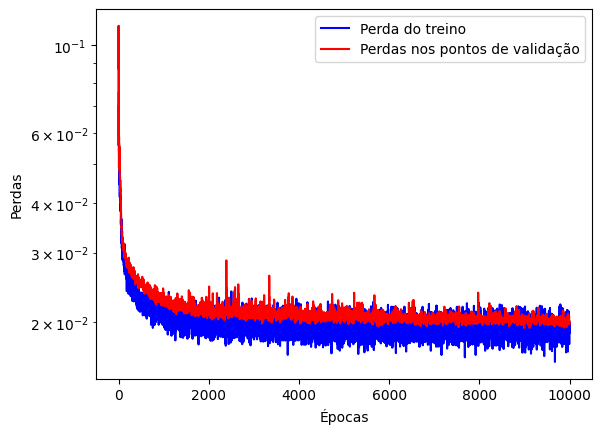

In [10]:
pinn_burgers.plot_comparacao()